In [31]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Drop "Naive Bayes columns" from BankChurners.csv & Display the first few rows 

In [32]:
# Load the original dataset
file_path = '../dataset/BankChurners.csv'
df = pd.read_csv(file_path)

# Drop Naive Bayes columns
columns_to_drop = [
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
]
df_clean = df.drop(columns=columns_to_drop)

# Display the first few rows 
print("Initial Rows:")
print(df_clean.head())
print("\nDataset Info:")
print(df_clean.info())

Initial Rows:
   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1   

### Plot the data

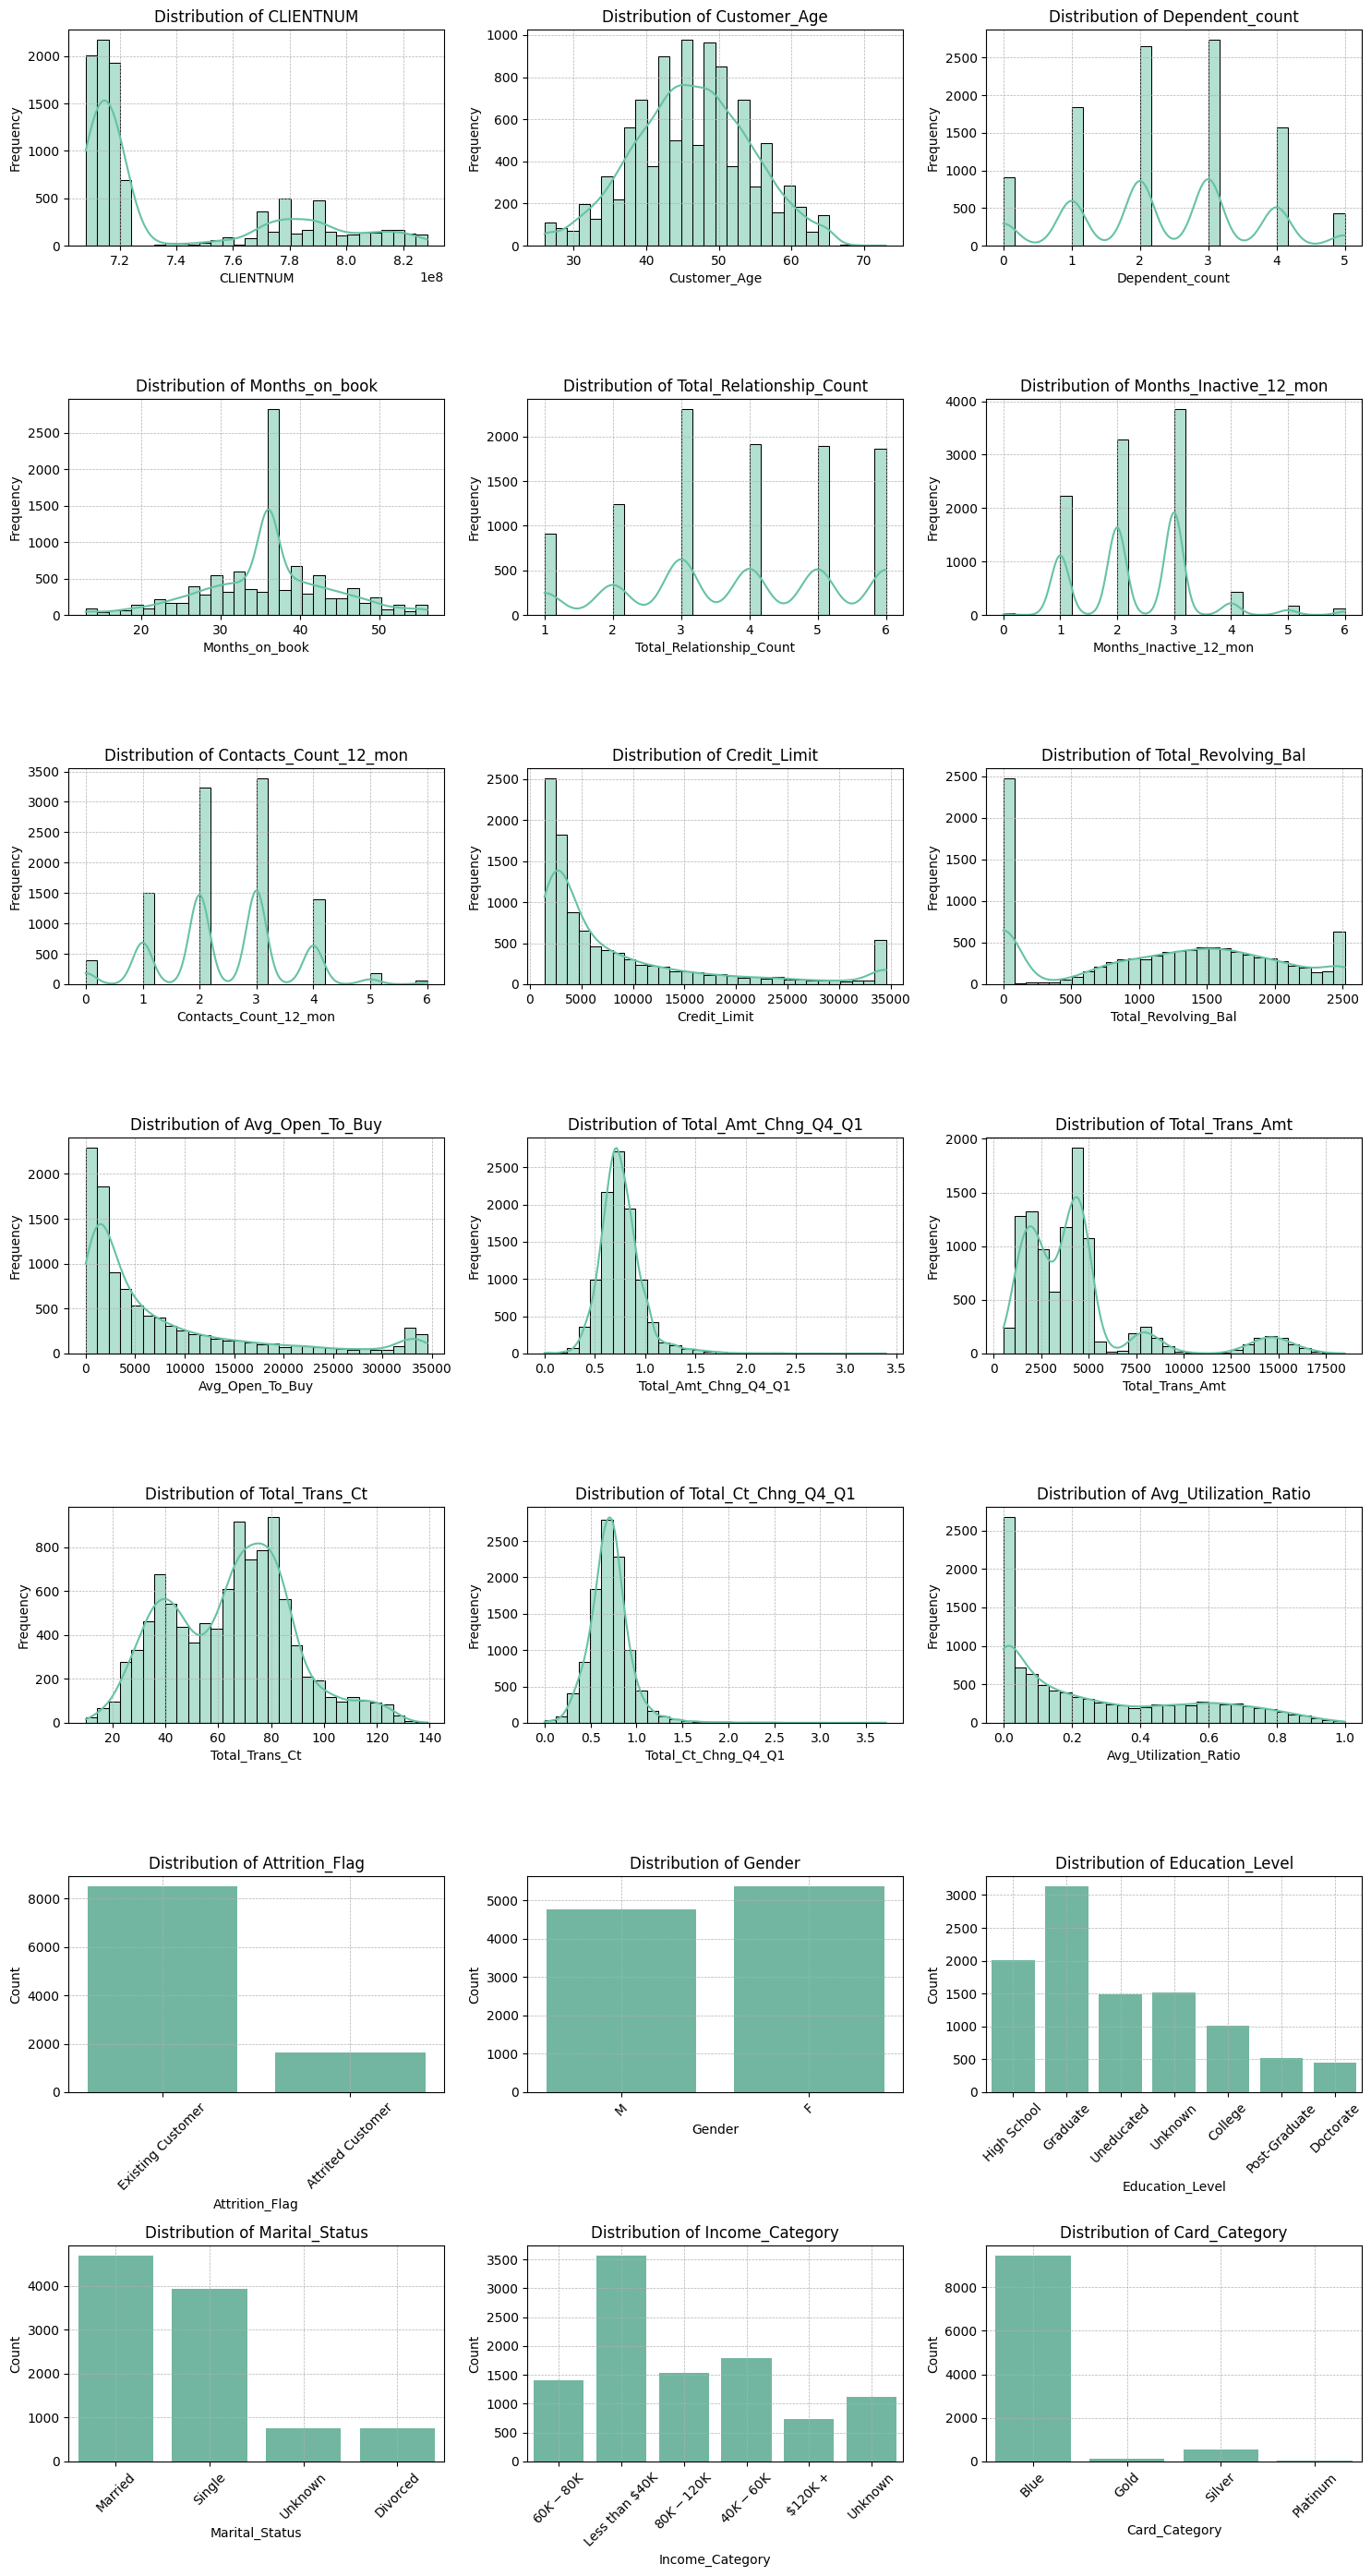

In [33]:
# Separate numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Combine numeric and categorical columns into one list
all_cols = list(numeric_cols) + list(categorical_cols)

# Create a grid to display all plots side by side in 3 columns
cols_per_row = 3
total_plots = len(all_cols)
rows = (total_plots + cols_per_row - 1) // cols_per_row

# Create subplots figure
fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 4 * rows))
axes = axes.flatten()

# Loop through columns to plot each in its appropriate subplot
for i, col in enumerate(all_cols):
    if col in numeric_cols:
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
        axes[i].set_ylabel('Frequency')
    else:
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].grid(visible=True, linestyle='--', linewidth=0.5)

# Remove any empty subplots
for j in range(i + 1, rows * cols_per_row):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Correlation matrix
- Months_on_book is positively correlated with Customer_Age (0.79) and with Total_Relationship_Count (0.79) 
    - Older customers tend to have longer-standing accounts, as expected
    - Older customers tend to use more services
- Total_Trans_Amt and Total_Trans_Ct are very strongly correlated (0.81): customers who make more transactions also tend to have higher transaction amounts, as expected
- Utilization Ratio:
    - Avg_Utilization_Ratio (average credit utilization) is negatively correlated with Credit_Limit (-0.48). As credit limits increase, utilization rates tend to drop because customers are using a smaller proportion of their available credit.
    - This ratio also negatively correlates with Total_Relationship_Count (-0.54), meaning that clients with more services usually have lower utilization ratios, this could indicate a better financial health.
- Total Amt Chng Q4 Q1 (change in transaction amounts between two quarters) is positively correlated with Total_Ct_Chng_Q4_Q1 (0.38), a higher change in the number of transactions => higher change in transaction amounts.

- Total Relationship Count: If this is a measure of how many products and services a customer has with the company, it could potentially including multiple credit cards?

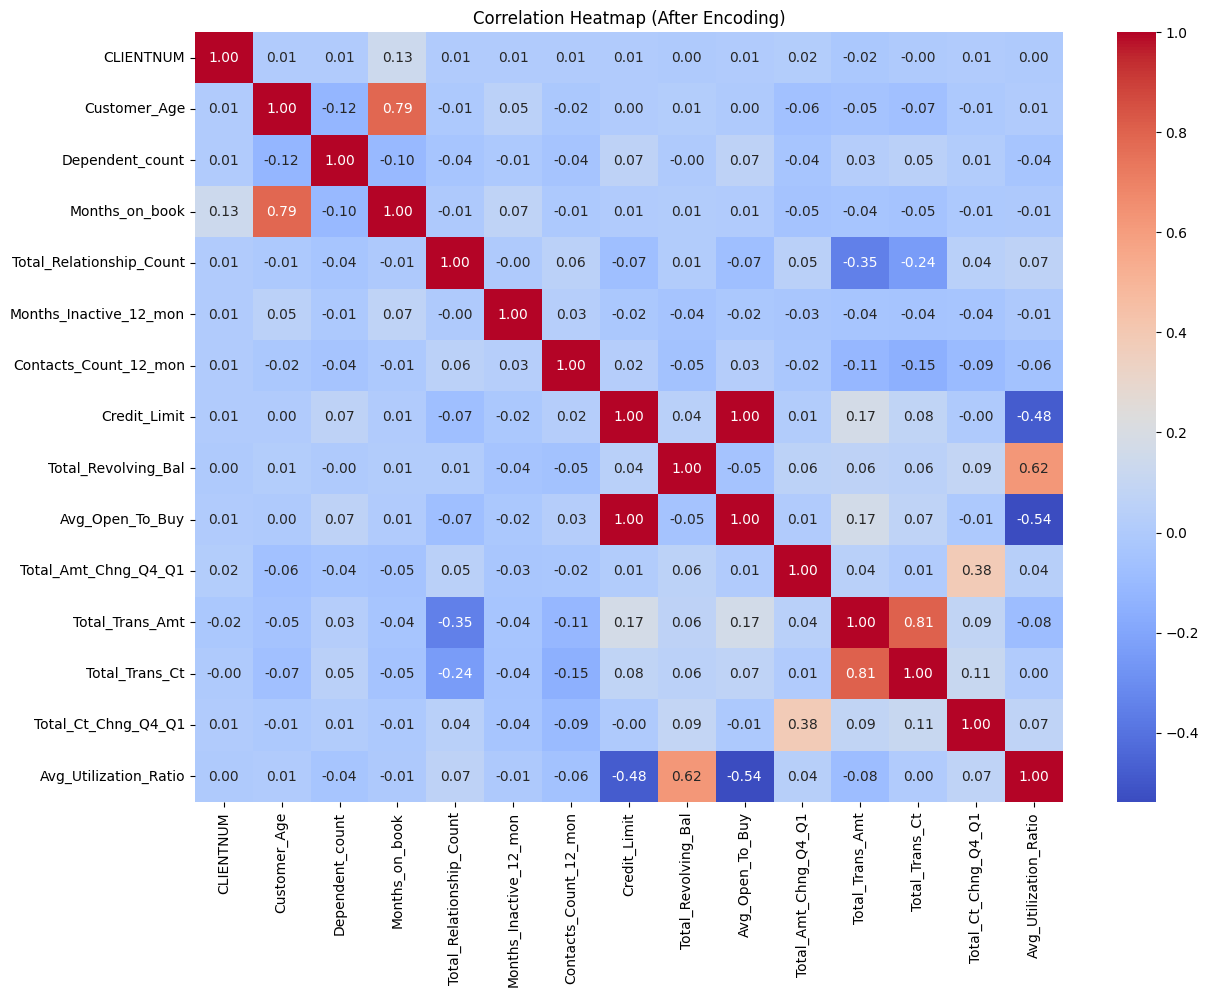

In [34]:
# One-Hot Encoding of relevant columns
df_encoded = pd.get_dummies(df_clean, columns=[
    'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'
], drop_first=True)

# Plot correlation matrix after encoding
numeric_columns = df_encoded.select_dtypes(include=['number'])
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap (After Encoding)")
plt.show()

### Save the clean, transformed data

In [35]:
# Save the clean, transformed data
df_encoded.to_csv('../dataset/BankChurners_transformed.csv', index=False)

## Finding ClientNum Relationships and Insights
### Are lower ClientNum numbers indicative of older clients, and Is there a relationship with other data?

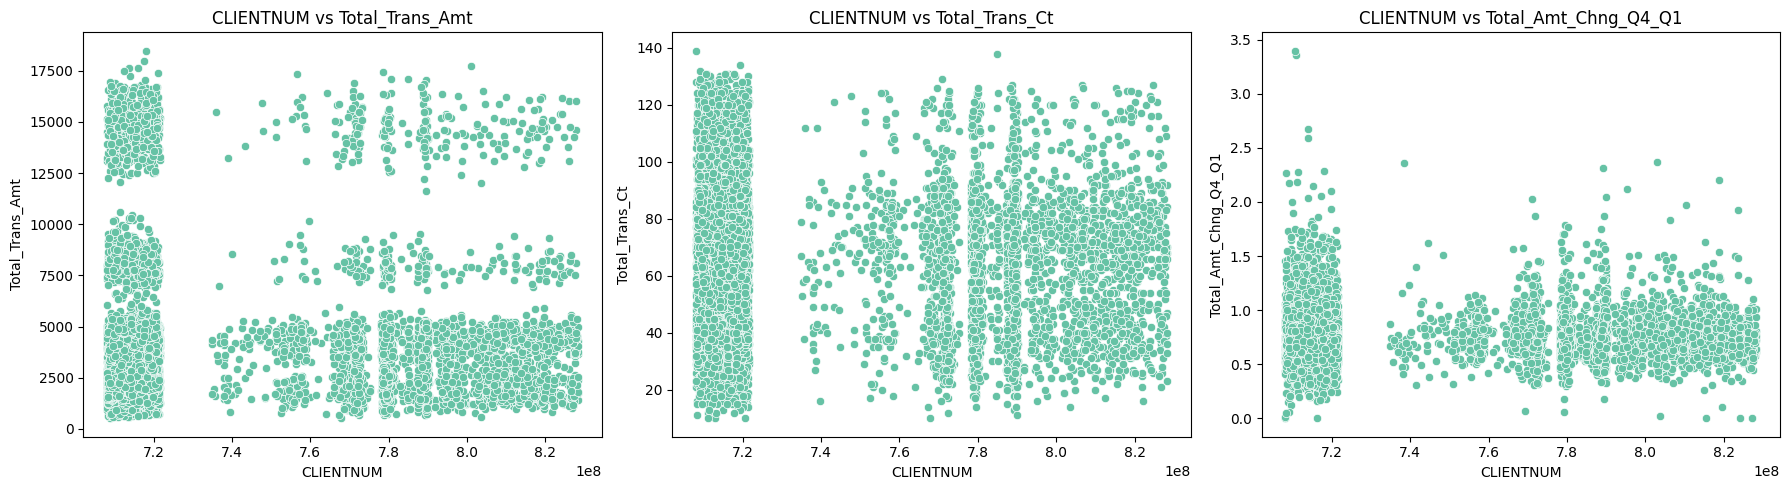

In [40]:
# Create scatter plots for the relationships
plot_df = df[['CLIENTNUM', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Amt_Chng_Q4_Q1']]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x='CLIENTNUM', y='Total_Trans_Amt', data=plot_df, ax=axes[0])
axes[0].set_title('CLIENTNUM vs Total_Trans_Amt')
axes[0].set_xlabel('CLIENTNUM')
axes[0].set_ylabel('Total_Trans_Amt')

sns.scatterplot(x='CLIENTNUM', y='Total_Trans_Ct', data=plot_df, ax=axes[1])
axes[1].set_title('CLIENTNUM vs Total_Trans_Ct')
axes[1].set_xlabel('CLIENTNUM')
axes[1].set_ylabel('Total_Trans_Ct')

sns.scatterplot(x='CLIENTNUM', y='Total_Amt_Chng_Q4_Q1', data=plot_df, ax=axes[2])
axes[2].set_title('CLIENTNUM vs Total_Amt_Chng_Q4_Q1')
axes[2].set_xlabel('CLIENTNUM')
axes[2].set_ylabel('Total_Amt_Chng_Q4_Q1')

plt.tight_layout()
plt.show()


### Distribution of Attrited and Existing Customers per CLIENTNUM Range

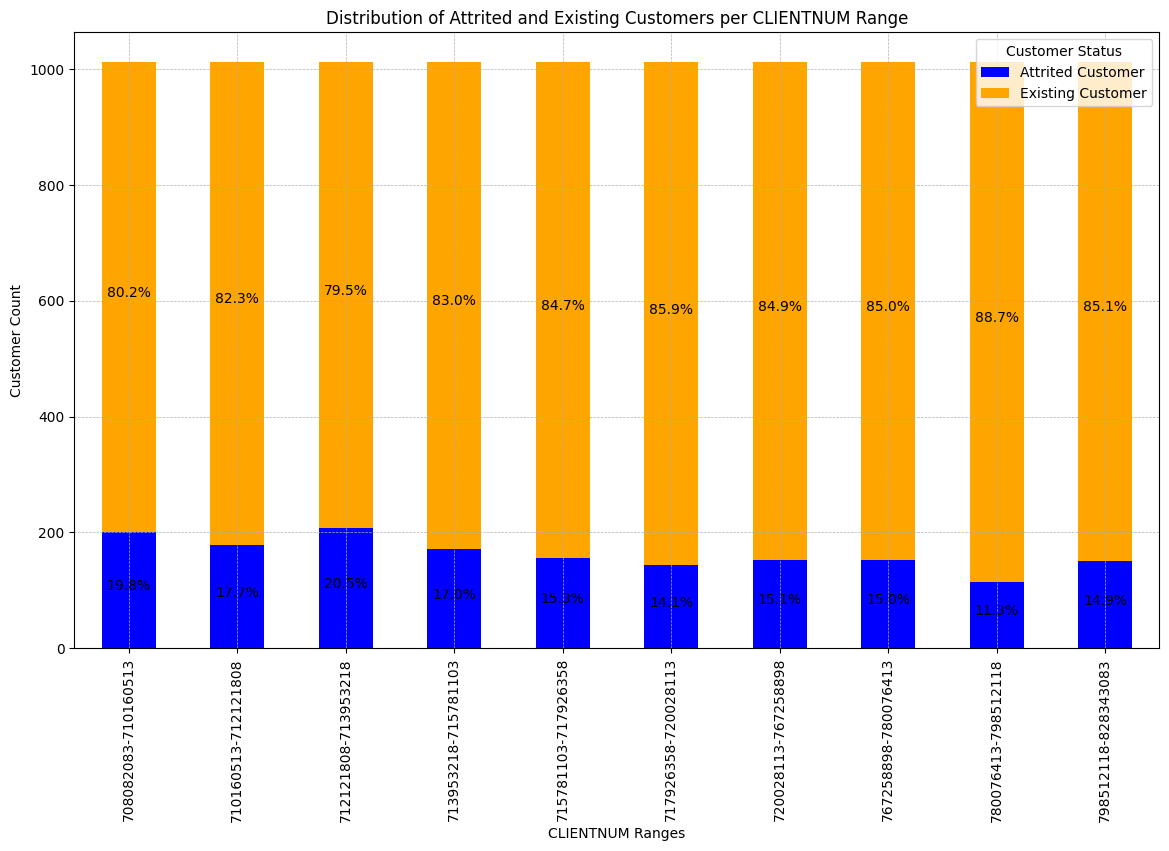

In [46]:
# Divide the clients into 10 groups based on sorted `CLIENTNUM`
quantiles, bins = pd.qcut(df['CLIENTNUM'], q=10, retbins=True, labels=False)
ranges = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins) - 1)]

# Assign label based on the `CLIENTNUM` range
df['ClientNum_Range'] = pd.qcut(df['CLIENTNUM'], q=10, labels=ranges)

# Aggregate counts per range per attrition flag (observed=True is explicitly set to suppress warning)
attrition_grouped = df.groupby(['ClientNum_Range', 'Attrition_Flag'], observed=True).size().unstack(fill_value=0)

# Plotting the grouped data as a bar chart
ax = attrition_grouped.plot(kind='bar', stacked=True, figsize=(14, 8), color=['blue', 'orange'])
ax.set_xlabel('CLIENTNUM Ranges')
ax.set_ylabel('Customer Count')
ax.set_title('Distribution of Attrited and Existing Customers per CLIENTNUM Range')
ax.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend(title='Customer Status')

# Annotate each bar with a percentage of Existing Customers
totals = attrition_grouped.sum(axis=1)
for i, p in enumerate(ax.patches):
    bar_index = i % len(attrition_grouped)  # Get the bar index using modulo
    height = p.get_height()
    percentage = '{:1.1f}%'.format(100 * height / totals.iloc[bar_index])
    ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., percentage, ha="center")

plt.show()


### Relationship between CLIENTNUM and Months on Book

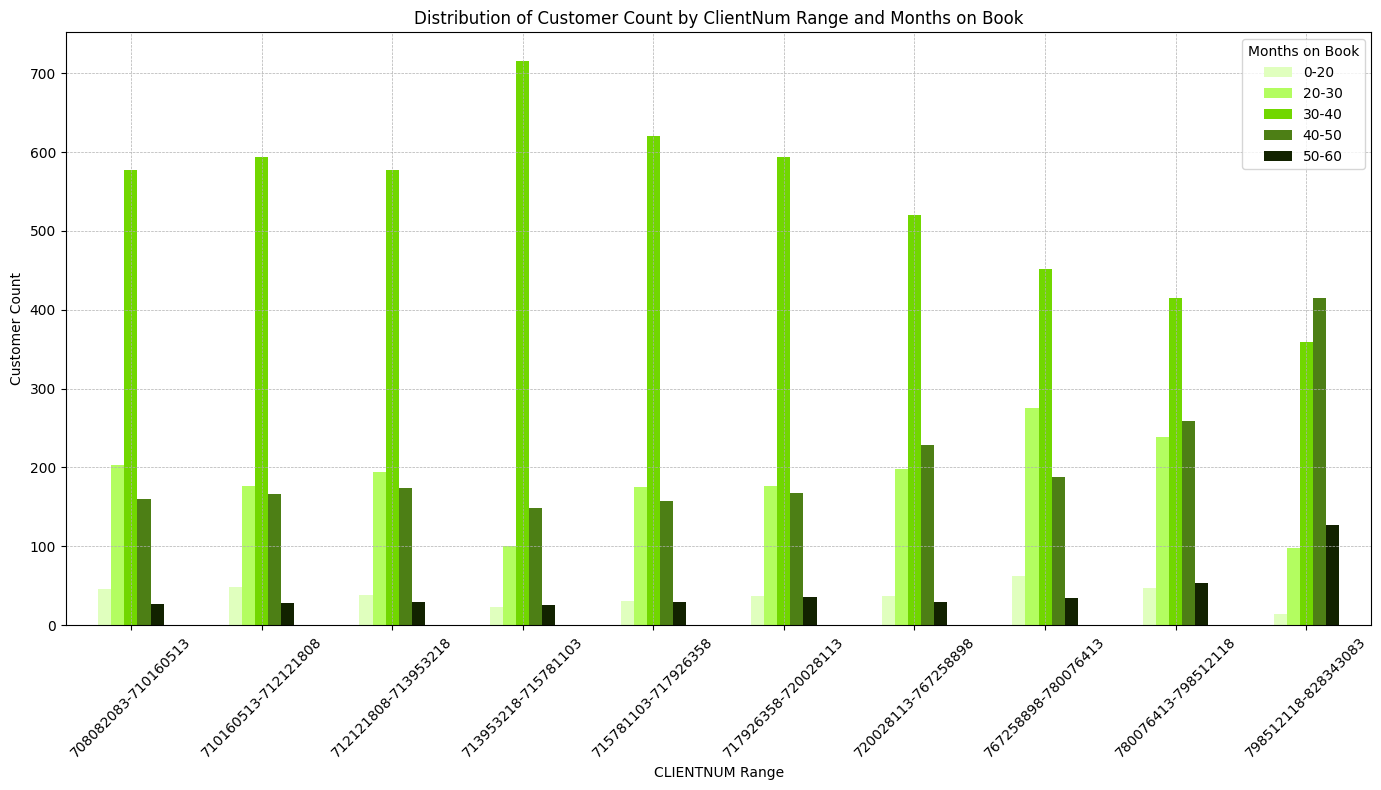

In [57]:
# Split clients into 10 groups based on `CLIENTNUM`
quantiles, bins = pd.qcut(df['CLIENTNUM'], q=10, retbins=True, labels=False)
ranges = [f'{int(bins[i])}-{int(bins[i + 1])}' for i in range(len(bins) - 1)]

# Assign a label based on the `CLIENTNUM` range
df['ClientNum_Range'] = pd.qcut(df['CLIENTNUM'], q=10, labels=ranges)

# Define the bins for `Months_on_book`
months_bins = [0, 20, 30, 40, 50, 60]
months_labels = ['0-20', '20-30', '30-40', '40-50', '50-60']
df['Months_Bin'] = pd.cut(df['Months_on_book'], bins=months_bins, labels=months_labels)

# Grouping data with observed=False explicitly set
grouped_data = df.groupby(['ClientNum_Range', 'Months_Bin'], observed=False).size().unstack(fill_value=0)

# Proceed with plotting as usual
greens = ['#E0FFBE', '#B3FD60', '#71D700', '#4D7F15', '#122200']

grouped_data.plot(kind='bar', stacked=False, figsize=(14, 8), color=greens)
plt.xlabel('CLIENTNUM Range')
plt.ylabel('Customer Count')
plt.title('Distribution of Customer Count by ClientNum Range and Months on Book')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.legend(title='Months on Book')
plt.tight_layout()
plt.show()




### Total Transaction Amount vs. Months on Book with ClientNum Ranges

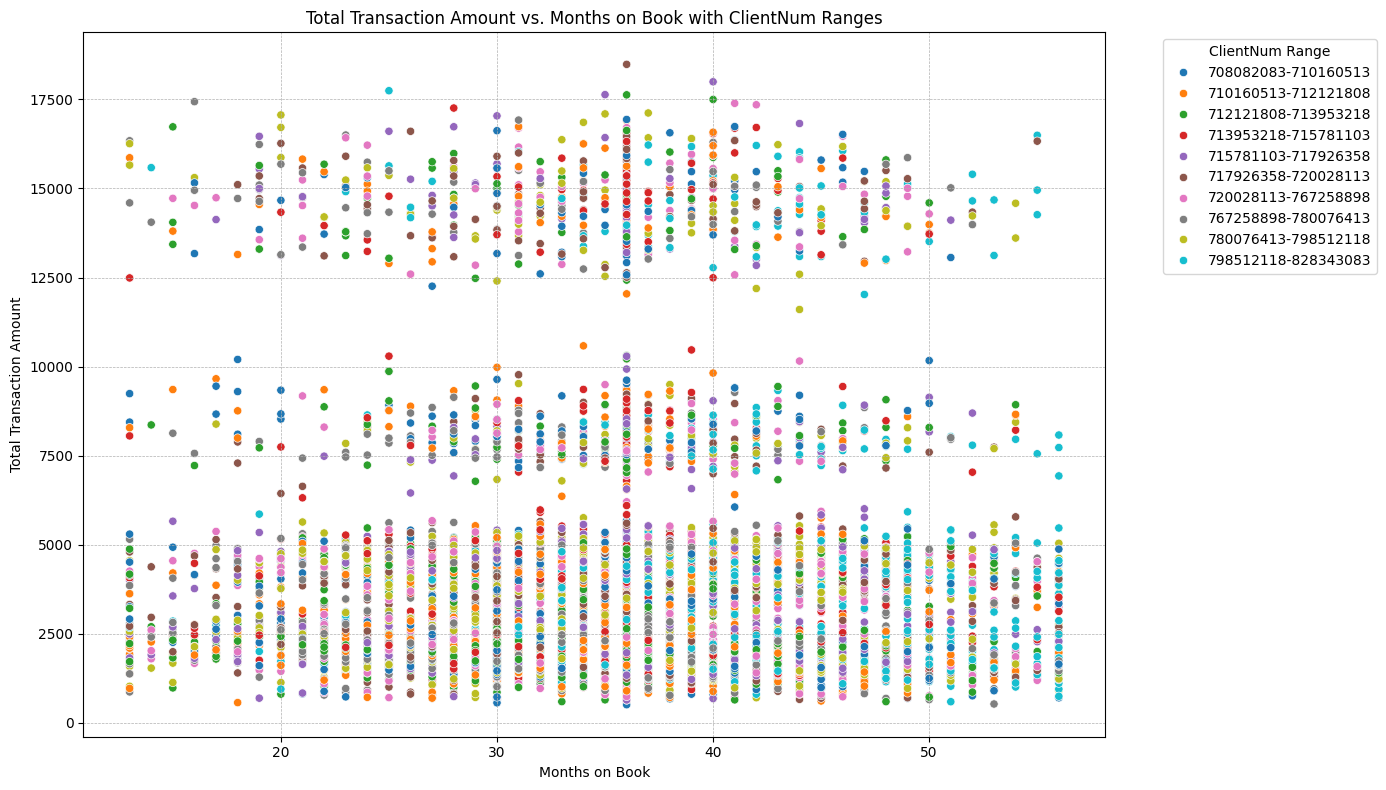

In [50]:
# Split into 10 groups based on `CLIENTNUM`
df['ClientNum_Range'], bins = pd.qcut(df['CLIENTNUM'], q=10, retbins=True, labels=False)
ranges = [f'{int(bins[i])}-{int(bins[i + 1])}' for i in range(len(bins) - 1)]

# Assign labels based on quantile ranges
df['ClientNum_Range'] = pd.qcut(df['CLIENTNUM'], q=10, labels=ranges)

# Create a scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='Months_on_book',
    y='Total_Trans_Amt',
    hue='ClientNum_Range',
    data=df,
    palette='tab10',
    legend='full'
)
plt.xlabel('Months on Book')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount vs. Months on Book with ClientNum Ranges')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend(title='ClientNum Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



## Conclusion
1. Older Clients and ClientNum: 
    - The data does not clearly indicate a consistent trend that lower ClientNum correlates directly with older accounts
    - While the distribution of "Months on Book" varies within each ClientNum range, it's evident that clients in all ranges show diverse ages of account relationships
2. Churn Analysis: 
     - All groups have a majority of existing customers
3. Services Usage: 
    - The correlation heatmap highlights relationships between different customer behavior features. For instance, "Total_Relationship_Count" correlates negatively with "Avg_Utilization_Ratio," indicating clients using multiple services often have a better credit usage ratio.

## Key Takeaways, questions for the client:

- The relationship between ClientNum and the age of clients' relationships isn't straightforward. What additional data or segmentation could provide a more clear trend?
